In [3]:
from models import BaselineModel
from data import Dataset, make_loader
from utils import filter_img_paths
from metrics import calc_ced, count_ced_auc
from config import *

%load_ext autoreload
%autoreload 2

In [4]:
import os.path
from pathlib import Path
import matplotlib.pyplot as plt

# plt.style.use('dark_background')

TRAIN_PATH_300W = os.path.join(DATA_DIR, '300W/train')
TRAIN_PATH_MENPO = os.path.join(DATA_DIR, 'Menpo/train')

TEST_PATH_300W = os.path.join(DATA_DIR, '300W/test')
TEST_PATH_MENPO = os.path.join(DATA_DIR, 'Menpo/test')

In [5]:
test_paths = filter_img_paths([Path(TEST_PATH_MENPO).glob('*.jpg')], check_box=True)
test_ds, test_dl = make_loader(test_paths, mode='test', batch_size=BATCH_SIZE, num_workers=0, k=0.3)

In [6]:
model = BaselineModel()
model_path = os.path.join(LOG_DIR, 'checkpoints/model.best.pth')
model.load_state_dict(torch.load(model_path))
model.cuda()
model.eval();

In [7]:
from torchvision import transforms
inv_trans = transforms.Compose([ 
    transforms.Normalize(mean=[0., 0., 0.],
                         std=[1/0.229, 1/0.224, 1/0.225]),
    transforms.Normalize(mean=[ -0.485, -0.456, -0.406 ],
                         std=[ 1., 1., 1. ])
])

def tensor2img(img):
    img = inv_trans(img)
    img = img.permute(1, 2, 0).numpy()
    img = (img * 255).astype('uint8')
    img = np.ascontiguousarray(img)
    return img

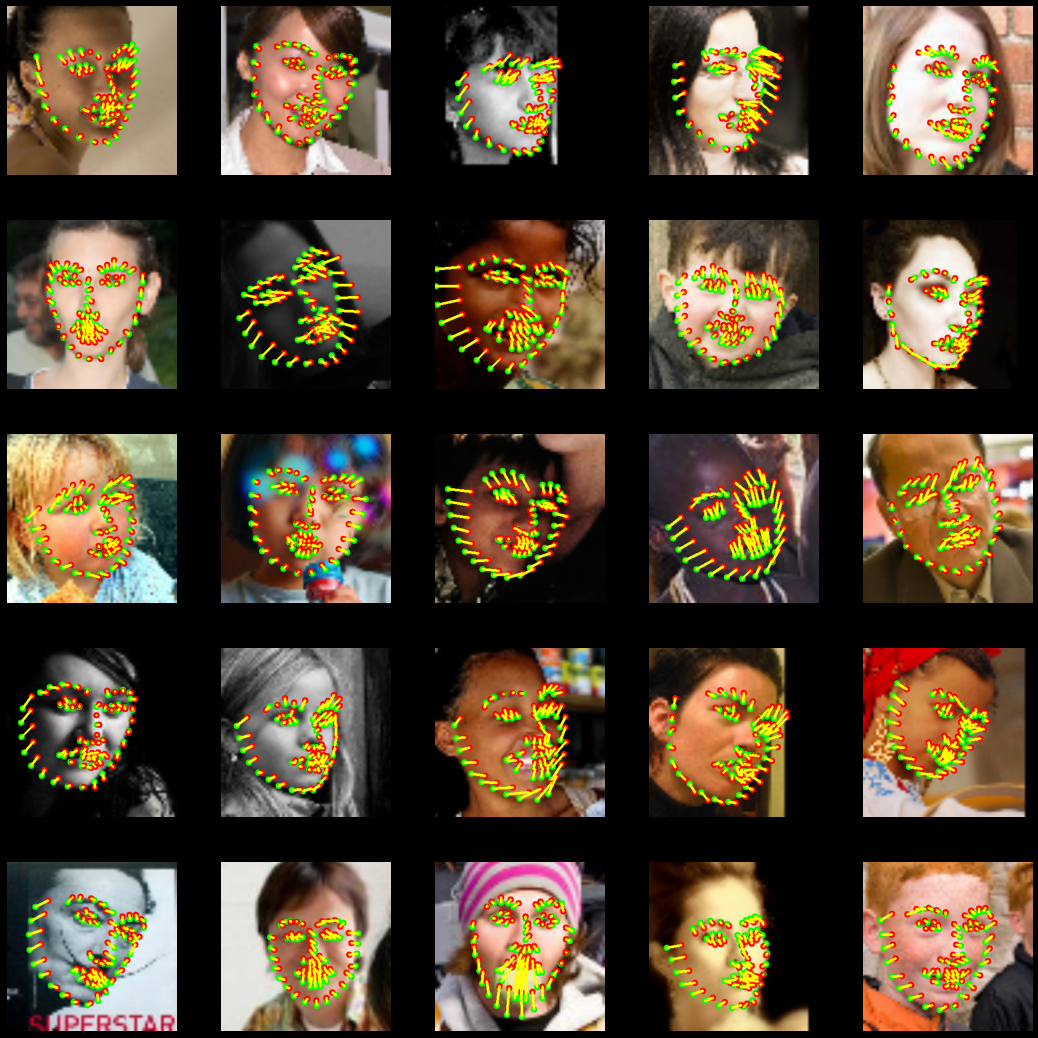

In [29]:
import matplotlib.pyplot as plt
import cv3

fig, axs = plt.subplots(5, 5, figsize=(15,15))

fig.tight_layout()

for i, ax in enumerate(axs.ravel(), start=9):
    data = test_ds[i]
    img = data['features']
    targets = data['targets']
    
    targets = targets.reshape(-1, 2)

    pred = model(img[None].cuda())[0].cpu().detach().reshape(-1, 2)

    img = tensor2img(img)
    
    img = cv3.resize(img, 5, 5, relative=True)

    r = int(0.02 * len(img))
    t = int(0.01 * len(img))


    for x, y in targets:
        cv3.point(img, x, y, r=r, color=(0, 255, 0), relative=True)

    for x, y in pred:
        cv3.point(img, x, y, r=r, color=(255, 0, 0), relative=True)

    for (x0,y0), (x1,y1) in zip(pred, targets):
        cv3.line(img, x0, y0, x1, y1, t=t, color=(255, 255, 0), relative=True)
    
    ax.imshow(img)
    # ax.set_title(str(i))
    ax.set_axis_off()

plt.show()

In [10]:
from catalyst import metrics
import torch

def get_scores(test_ds, test_dl):
    metric = metrics.AccumulativeMetric(keys=['ceds'], compute_on_call=False)
    metric.reset(test_dl.batch_size, len(test_ds))

    with torch.no_grad():
        for batch in tqdm(test_dl):
            x, y = batch['features'], batch['targets']

            logits = model(x.cuda()).cpu()

            ceds = calc_ced(logits, y, batch['width'], batch['height'])
            metric.update(ceds=ceds)
    return np.sort(metric.compute()['ceds'].numpy())

In [11]:
def plot_ced(ceds, error_thr=0.08):
    with plt.style.context('ggplot'):
        line_styles = [':', '-.', '--', '-']
        plt.figure(figsize=(15,12), dpi=70)
        for method_idx, method_name in enumerate(ceds.keys()):
            print('Plotting graph for the method {}'.format(method_name))
            err = ceds[method_name]
            proportion = np.arange(err.shape[0], dtype=np.float32) / err.shape[0]
            under_thr = err > error_thr
            last_idx = len(err)

            if len(np.flatnonzero(under_thr)) > 0:
                last_idx = np.flatnonzero(under_thr)[0]
            under_thr_range = range(last_idx)
            cur_auc = count_ced_auc(err)[0]

            plt.plot(
                err[under_thr_range], 
                proportion[under_thr_range], 
                label=method_name + ', auc={:1.2f}'.format(cur_auc),
                linestyle=line_styles[method_idx % len(line_styles)], 
                linewidth=2.0
            )
            plt.legend(loc='right', prop={'size': 12})

### Menpo

In [44]:
test_paths = filter_img_paths([Path(TEST_PATH_MENPO).glob('*.jpg')], check_box=True)
test_ds, test_dl = make_loader(test_paths, mode='test', batch_size=64, num_workers=0, k=0.3)

In [15]:
from test import get_ceds

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
scores_menpo = np.sort(get_ceds(model, test_ds))

100%|█████████████████████████████████████████████████████████████████████████████████████| 574/574 [00:08<00:00, 71.09it/s]


In [49]:
scores_dlib = np.load('scores_dlib.npy')

Plotting graph for the method dlib_model_Menpo
Plotting graph for the method model_aligned


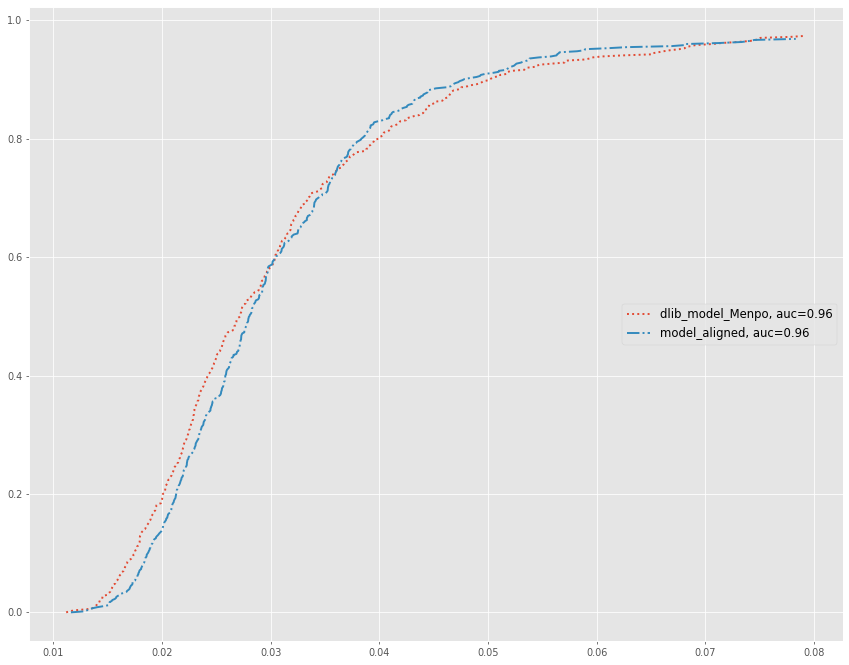

In [15]:
plot_ced({
    'dlib_model_Menpo': scores_dlib,
    'model_aligned': scores_menpo})

### 300W

In [16]:
test_paths = filter_img_paths([Path(TEST_PATH_300W).glob('*.jpg')], check_box=True)
test_ds, test_dl = make_loader(test_paths, mode='test', batch_size=64, num_workers=0, k=0.5)

In [17]:
scores_300w = np.sort(get_ceds(model, test_ds))

100%|█████████████████████████████████████████████████████████████████████████████████████| 263/263 [00:12<00:00, 20.65it/s]


Plotting graph for the method model_300w


Text(0.5, 1.0, 'CED для 300W')

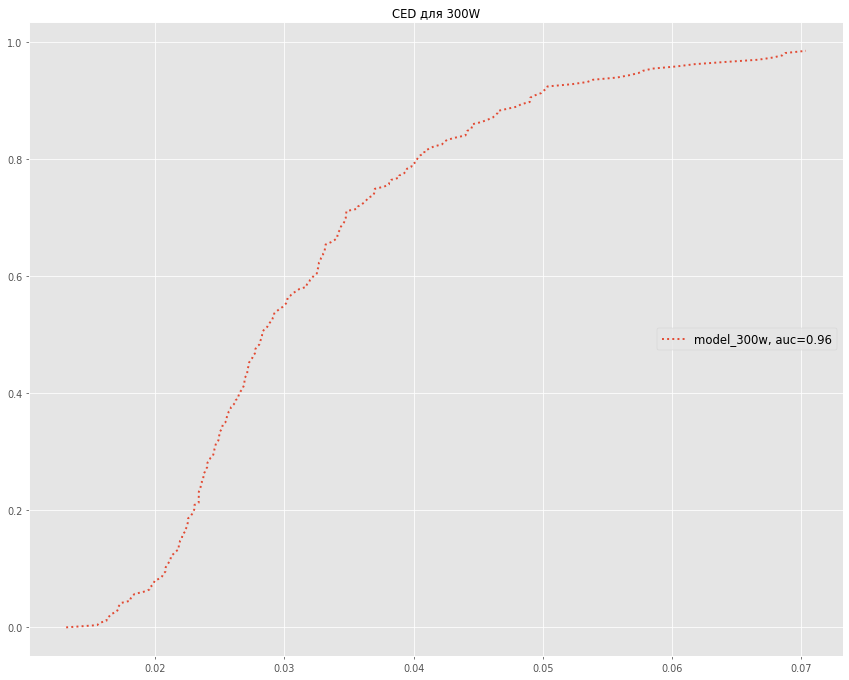

In [18]:
plot_ced({'model_300w': scores_300w})
plt.title('CED для 300W')